In [ ]:
import warnings 
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
import statsmodels.api as sm

color = sns.color_palette()
sns.set_style('darkgrid')

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Updated_bharwaraData.csv")
df.head()


,Day,Date,MLD_A,MLD_B,MLD_C,IN_PH,IN_DO,IN_TSS,IN_COD,IN_BOD,IN_MPN,OUT_PH,OUT_DO,OUT_TSS,OUT_COD,OUT_BOD,OUT_MPN
0,1.0,01-Apr-19,117.0,113.0,110.0,7.37,0.0,267.0,280.0,160.0,NaN,7.59,5.1,39.0,88.0,29.0,NaN
1,2.0,02-Apr-19,107.0,101.0,94.0,7.32,0.0,254.0,264.0,160.0,NaN,7.64,5.2,36.0,72.0,25.0,NaN
2,3.0,03-Apr-19,127.0,117.0,117.0,7.28,0.0,246.0,240.0,150.0,NaN,7.66,5.0,36.0,80.0,27.0,NaN
3,4.0,04-Apr-19,130.0,121.0,124.0,7.37,0.0,265.0,272.0,145.0,NaN,7.60,5.1,39.0,64.0,24.0,NaN
4,5.0,05-Apr-19,131.0,122.0,126.0,7.42,0.0,253.0,264.0,140.0,NaN,7.69,4.9,42.0,72.0,26.0,NaN


In [ ]:
df = df[["Date","MLD_A","MLD_B","MLD_C"]]
df = df.dropna()

In [ ]:
df['Total_MLD'] = df['MLD_A']+df['MLD_B']+df['MLD_C']
df.drop(columns = ["MLD_B", "MLD_C","MLD_A"],axis=1,inplace=True)

In [ ]:
df.head()

,Date,Total_MLD
0,01-Apr-19,340.0
1,02-Apr-19,302.0
2,03-Apr-19,361.0
3,04-Apr-19,375.0
4,05-Apr-19,379.0


In [ ]:
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)
df['Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')
df.head()
df.shape

(1138, 2)

In [ ]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.dayofyear
df['weekday'] = df['Date'].dt.weekday
df.head()

,Date,Total_MLD,year,month,day,weekday
0,2019-04-01,340.0,2019,4,91,0
1,2019-04-02,302.0,2019,4,92,1
2,2019-04-03,361.0,2019,4,93,2
3,2019-04-04,375.0,2019,4,94,3
4,2019-04-05,379.0,2019,4,95,4


## **Decompose the time series**

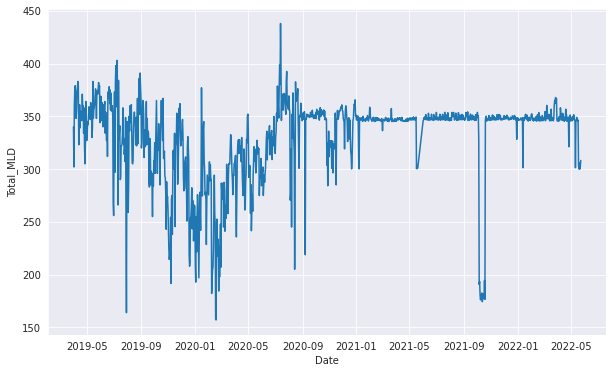

In [ ]:

daily_data = sns.lineplot(x='Date',y='Total_MLD',legend='full',data=df)
fig = daily_data.get_figure()
fig.set_size_inches(10, 6)
fig.savefig("Daily_data", dpi=300)

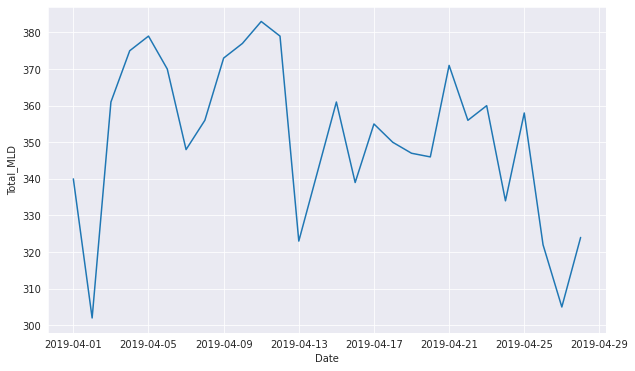

In [ ]:
monthly_data=sns.lineplot(x="Date", y="Total_MLD",legend = 'full' , data=df[:28])
fig = monthly_data.get_figure()
fig.set_size_inches(10, 6)
fig.savefig("monthly_data",dpi=250)

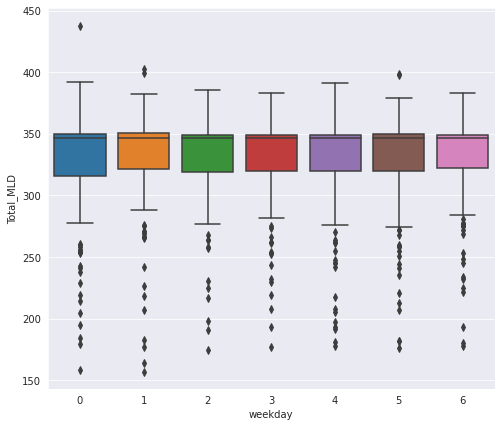

In [ ]:
boxPlot=sns.boxplot(x="weekday",y="Total_MLD",data=df)
fig = boxPlot.get_figure()
fig.set_size_inches(8, 7)
fig.savefig("boxPlot")

Here we can find that nearly every week has same amount of inflow and weekdays(0,1) has more outliers than the weekdays(2-6)  

In [ ]:
df = df.set_index('Date')
df['Total_MLD'] = df['Total_MLD'].astype(float)
df.head()

,Total_MLD,year,month,day,weekday
Date,,,,,
2019-04-01,340.0,2019,4,91,0
2019-04-02,302.0,2019,4,92,1
2019-04-03,361.0,2019,4,93,2
2019-04-04,375.0,2019,4,94,3
2019-04-05,379.0,2019,4,95,4


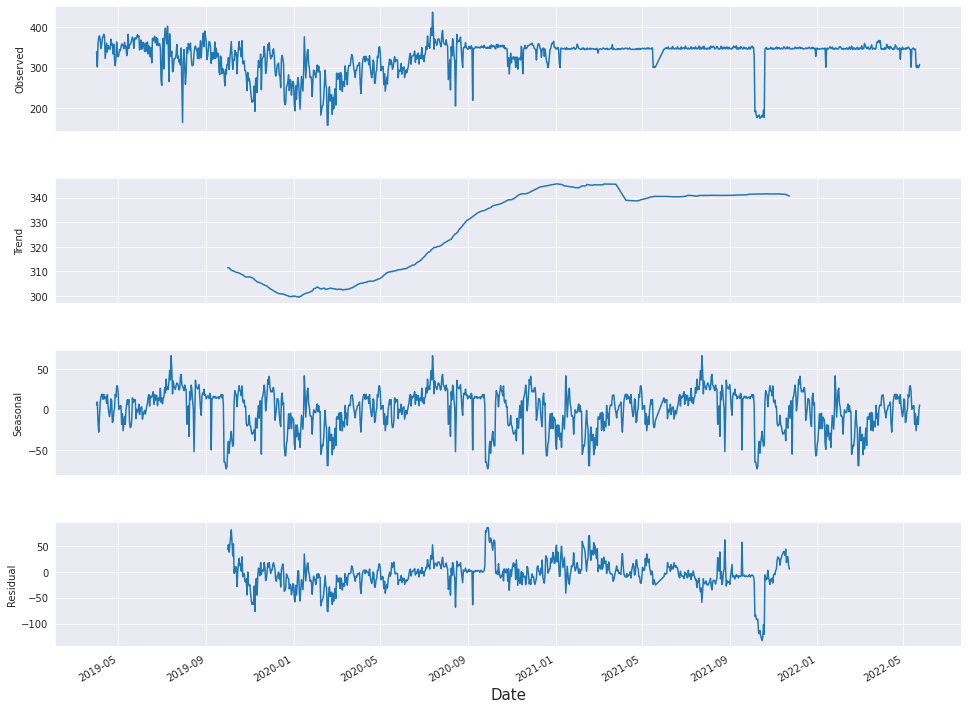

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Total_MLD'], model='additive', freq=365)

fig = plt.figure()  
fig = result.plot()
fig.set_y  
fig.set_size_inches(15, 12)
plt.xlabel("Date",fontsize=15)
fig.savefig("decompose")

The trend in the data set changes from low to high in middle months and stays at constant pace then

In [ ]:
from logging import critical
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.savefig("Rolling_Mean_after_intigration",dpi=200)
    plt.show()
    
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < 0.05 and adf< critical_value:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

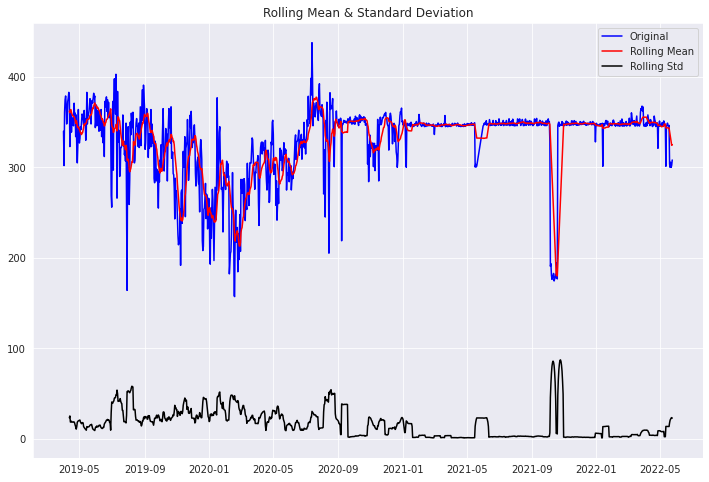

Results of Dickey-Fuller Test:
p-value = 0.0001. The series is likely stationary.
Test Statistic                   -4.698436
p-value                           0.000085
#Lags Used                       12.000000
Number of Observations Used    1125.000000
Critical Value (1%)              -3.436176
Critical Value (5%)              -2.864113
Critical Value (10%)             -2.568140
dtype: float64


In [ ]:
test_stationarity(df['Total_MLD'])

the p-value of 0.000085 is really good if we use 5% critical value this series has no continuous growing graph

Now the tas is to make series stationary using differencing

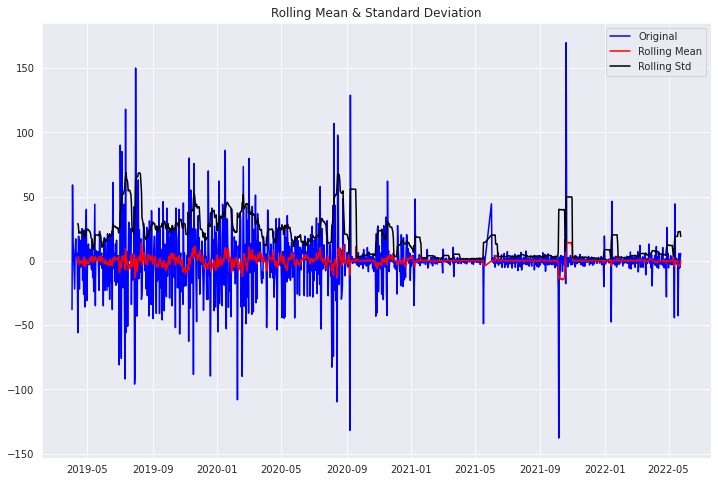

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.075267e+01
p-value                        2.640831e-19
#Lags Used                     1.700000e+01
Number of Observations Used    1.119000e+03
Critical Value (1%)           -3.436207e+00
Critical Value (5%)           -2.864126e+00
Critical Value (10%)          -2.568147e+00
dtype: float64


In [ ]:
first_diff = df.Total_MLD - df.Total_MLD.shift(1)
first_diff = first_diff.dropna(inplace=False)
test_stationarity(first_diff, window=12)

After differencing, the p-value is extremely small. Thus this series is very likely to be stationary.

# ACF and PACF

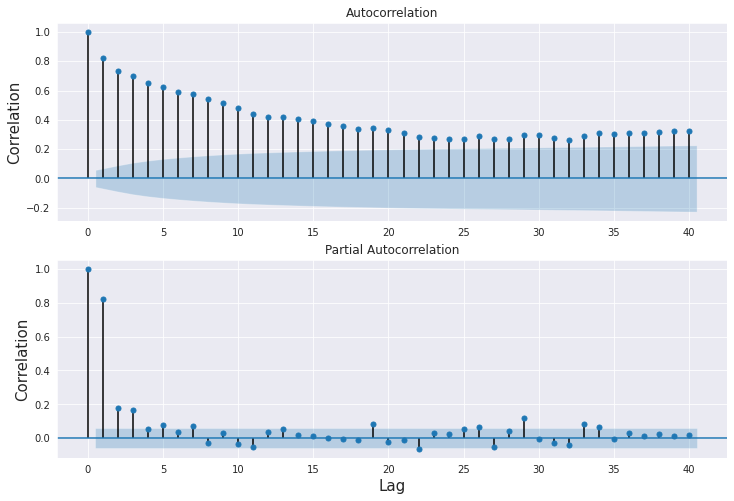

In [ ]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8),)
ax1 = fig.add_subplot(211)
ax1.set_ylabel("Correlation",fontsize=15)
fig = sm.graphics.tsa.plot_acf(df.Total_MLD, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
ax2.set_ylabel("Correlation",fontsize=15)
ax2.set_xlabel("Lag",fontsize=15)
fig = sm.graphics.tsa.plot_pacf(df.Total_MLD, lags=40, ax=ax2)# , lags=40
fig.savefig("ACF_original",dpi=200)

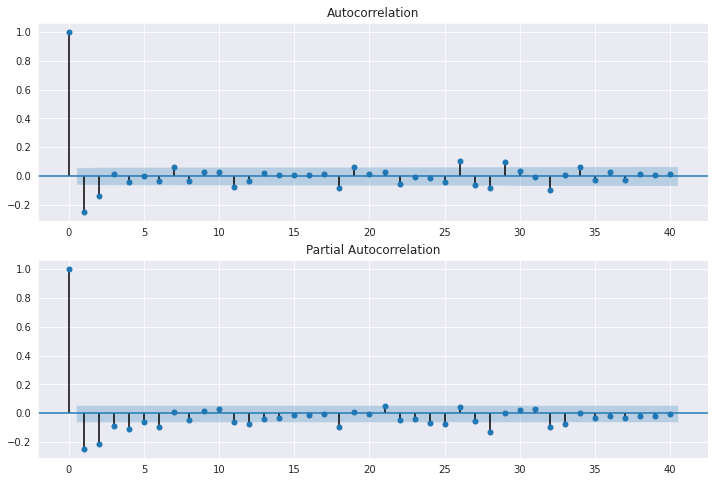

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)
fig.savefig("ACF_intigration",dpi=200)

As we can a sudden cut to the PACF at lag 3 and ACF to be gradually decreasing from lag 3 the AR(p) value with 3 will give the better result.
And for selecting the order of the MA(q) we can say just opposite. and select the MA(q)  to 3

## Build The  Model

In [ ]:
arima_mod = sm.tsa.ARIMA(df['Total_MLD'],order= (3,1,3)).fit(disp=False)
print(arima_mod.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:            D.Total_MLD   No. Observations:                 1137
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -5097.559
Method:                       css-mle   S.D. of innovations             21.412
Date:                Thu, 02 Jun 2022   AIC                          10211.117
Time:                        18:11:45   BIC                          10251.407
Sample:                             1   HQIC                         10226.334
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0103      0.073     -0.141      0.888      -0.154       0.133
ar.L1.D.Total_MLD     0.2780      0.108      2.576      0.010       0.067       0.489
ar.L2.D.Total_MLD     0.

NormaltestResult(statistic=294.1364546714812, pvalue=1.3461095482043934e-64)


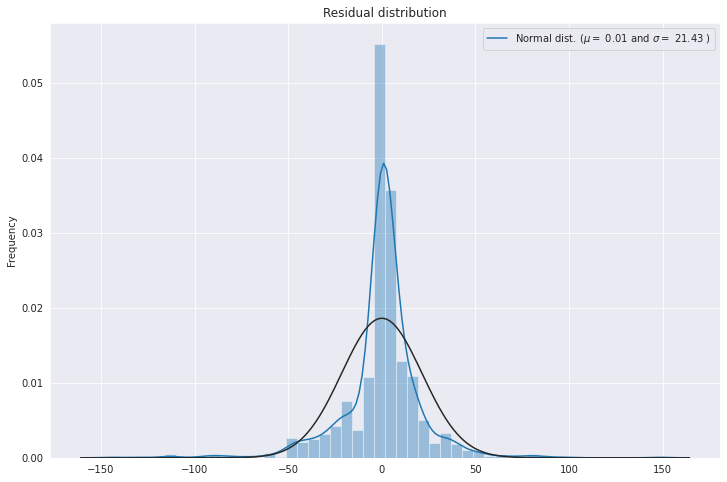

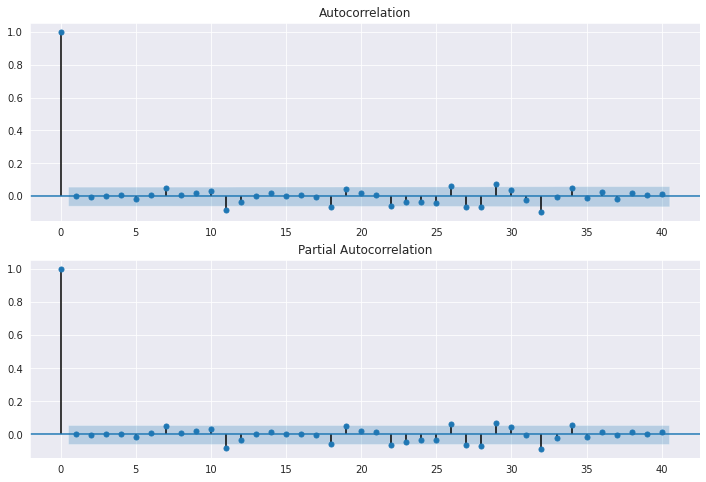

In [ ]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_mod.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')
plt.savefig("resid_ARIMA",dpi=200)


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod.resid, lags=40, ax=ax2)
fig.savefig("After_Arima",dpi=200)


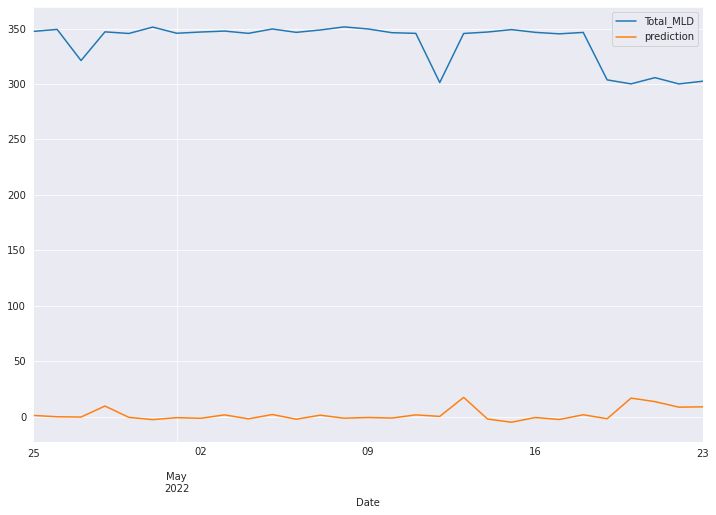

In [ ]:
#Arima Result
start = 1108
end = 1137
df['prediction'] = arima_mod.predict(start = start, end = end)
ax = df[start:end][['Total_MLD', 'prediction']].plot(figsize=(12,8))
fig = ax.get_figure()
fig.savefig("Arima_Result",dpi=200)

## Predictions

In [ ]:
df.shape

(1138, 6)

In [ ]:
sarima_mod = sm.tsa.statespace.SARIMAX(df.Total_MLD, trend='n', order=(3,1,3)).fit()
print(sarima_mod.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:              Total_MLD   No. Observations:                 1138
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -5097.585
Date:                Thu, 02 Jun 2022   AIC                          10209.170
Time:                        18:11:58   BIC                          10244.423
Sample:                             0   HQIC                         10222.485
                               - 1138                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2636      0.087      3.042      0.002       0.094       0.433
ar.L2          0.7840      0.080      9.769      0.000       0.627       0.941
ar.L3         -0.1935      0.077     -2.507      0.0

NormaltestResult(statistic=724.1785490302149, pvalue=5.5798962216619735e-158)


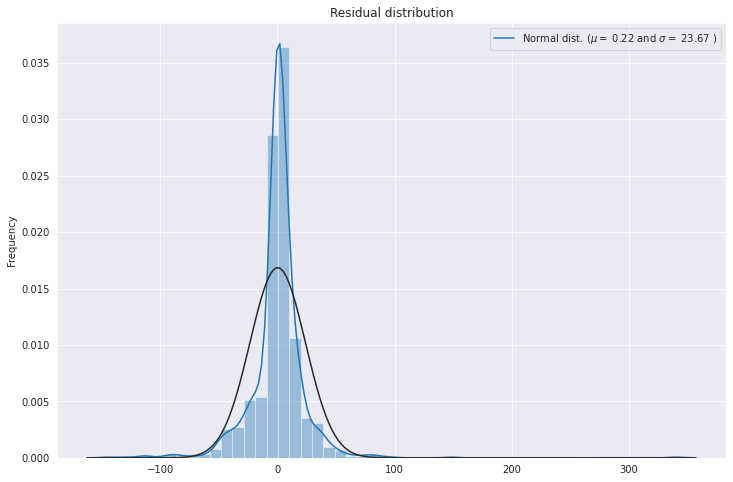

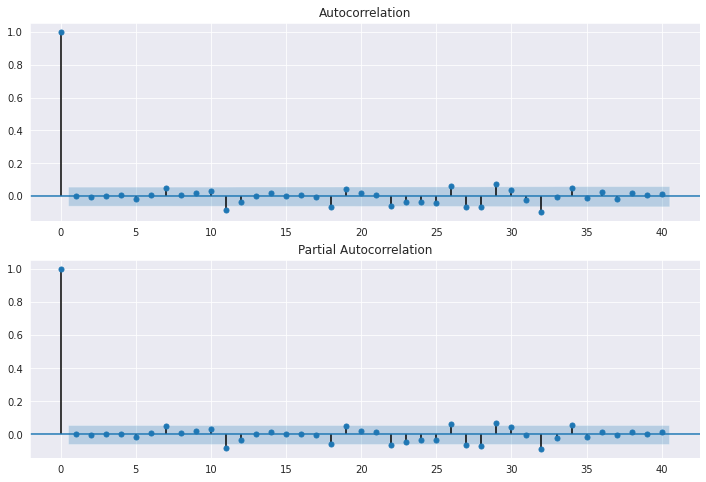

In [ ]:
resid = sarima_mod.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')
plt.savefig("resid_Sarima",dpi=200)

# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod.resid, lags=40, ax=ax2)
fig.savefig("ACF_sarima",dpi=200)

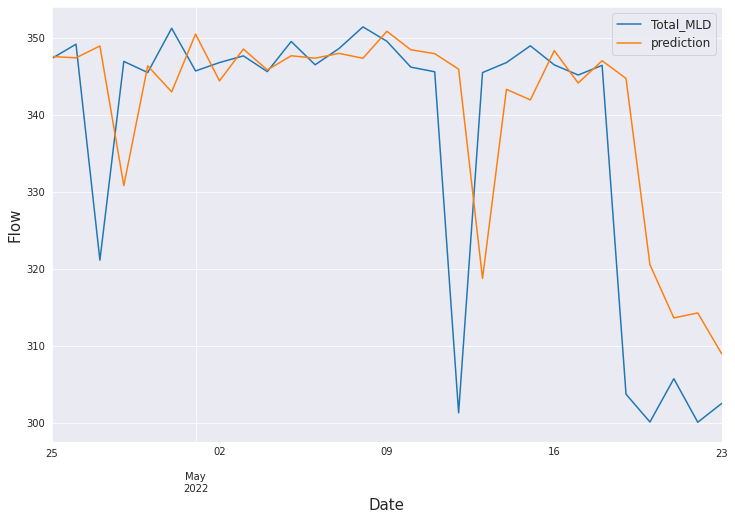

In [ ]:
start = 1108
end = 1137
df['prediction'] = sarima_mod.predict(start = start, end = end)
ax = df[start:end][['Total_MLD', 'prediction']].plot(figsize=(12,8))
ax.set_xlabel("Date",fontdict={'fontsize':15})
ax.set_ylabel("Flow",fontdict={'fontsize':15})
plt.legend(fontsize=12)
fig = ax.get_figure()
fig.savefig("Result",dpi=200)

In [ ]:
def smape_errorMatric(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [ ]:
smape_errorMatric(df[start:end]['Total_MLD'],df[start:end]['prediction'])

MAPE: 2.73 % 
SMAPE: 2.65 %


## SEASONAL ORDER

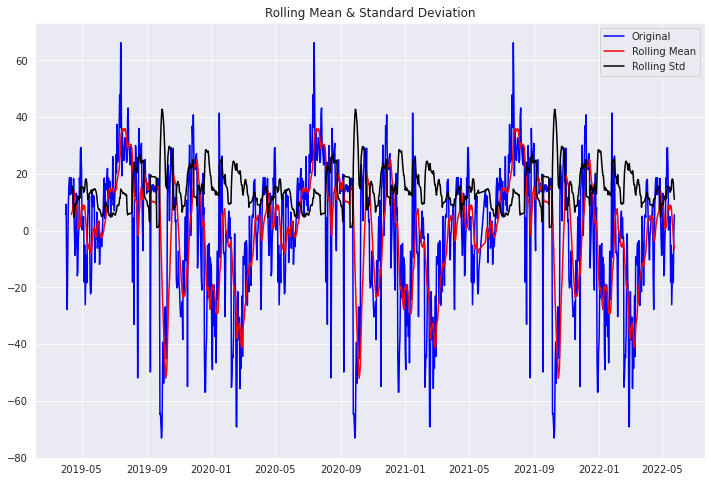

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                   -5.566000
p-value                           0.000002
#Lags Used                       20.000000
Number of Observations Used    1117.000000
Critical Value (1%)              -3.436218
Critical Value (5%)              -2.864131
Critical Value (10%)             -2.568150
dtype: float64


In [ ]:
seasonal = result.seasonal
test_stationarity(seasonal, window=12)

The seasonal component is stationary

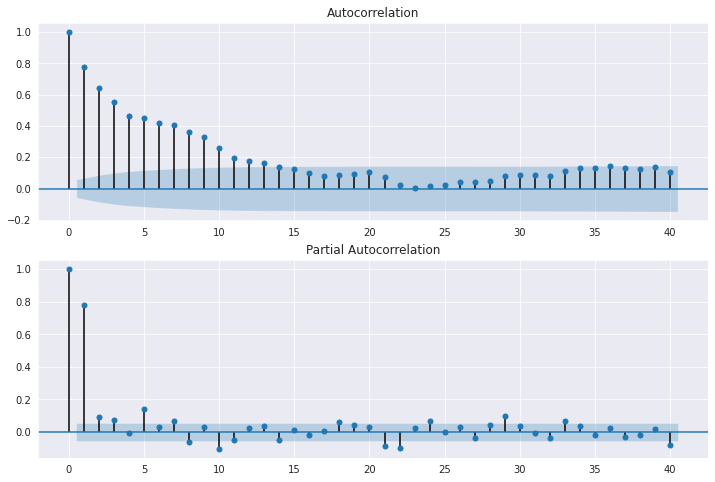

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(seasonal, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(seasonal, lags=40, ax=ax2)# , lags=40
fig.savefig("ACF_Seasonal",dpi=200)

In [ ]:
P = 3
Q = 3
sarima_seasonal_mod = sm.tsa.statespace.SARIMAX(df.Total_MLD, order=(3,1,3),seasonal_order=(P,0,Q,5)).fit()
print(sarima_seasonal_mod.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:                         Total_MLD   No. Observations:                 1138
Model:             SARIMAX(3, 1, 3)x(3, 0, 3, 5)   Log Likelihood               -5098.160
Date:                           Thu, 02 Jun 2022   AIC                          10222.320
Time:                                   18:12:21   BIC                          10287.790
Sample:                                        0   HQIC                         10247.047
                                          - 1138                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2006      0.100      1.997      0.046       0.004       0.397
ar.L2          0.8938      0.038     23.670

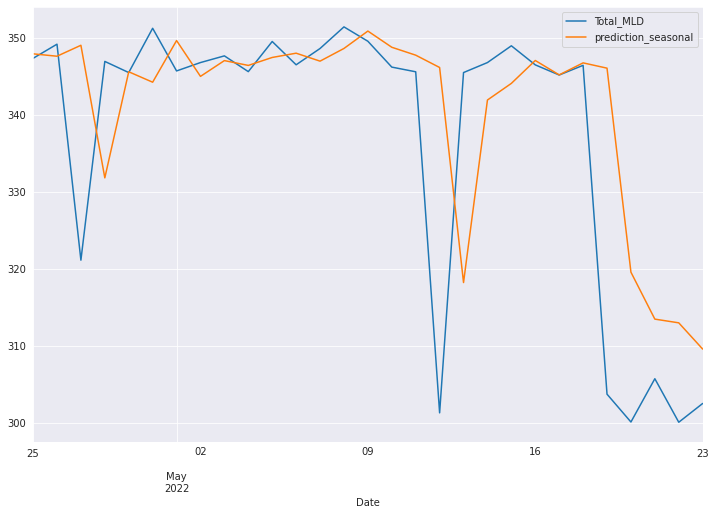

In [ ]:
start = 1108
end = 1137
df['prediction_seasonal'] = sarima_seasonal_mod.predict(start = start, end = end)
ax = df[start:end][['Total_MLD', 'prediction_seasonal']].plot(figsize=(12,8))
fig = ax.get_figure()
fig.savefig("Result",dpi=200)

In [ ]:
smape_errorMatric(df[start:end]['Total_MLD'],df[start:end]['prediction_seasonal'])

MAPE: 2.67 % 
SMAPE: 2.59 %


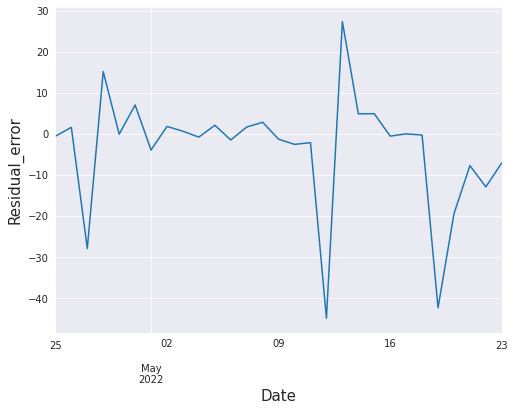

In [ ]:
residuals_SarimaO = df[start:end]['Total_MLD']-df[start:end]['prediction_seasonal']
residuals_SarimaO
ax2 = residuals_SarimaO.plot(xlabel="Date",ylabel="error",figsize=(8,6))
ax2.set_xlabel("Date", fontdict={'fontsize':15})
ax2.set_ylabel("Residual_error", fontdict={'fontsize':15})
fig = ax.get_figure()

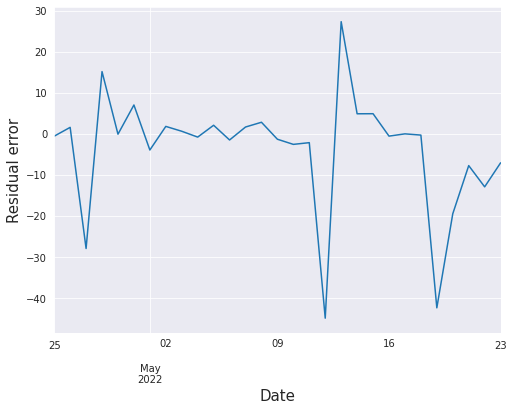

In [ ]:
residuals_Sarima = df[start:end]['Total_MLD']-df[start:end]['prediction']
residuals_SarimaO
ax2 = residuals_SarimaO.plot(xlabel="Date",ylabel="error",figsize=(8,6))
ax2.set_xlabel("Date", fontdict={'fontsize':15})
ax2.set_ylabel("Residual error", fontdict={'fontsize':15})
fig = ax2.get_figure()
fig.savefig("residual_error",dpi=250)